In [2]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pandas as pd
import numpy as np

import torch

from sklearn.preprocessing import StandardScaler

from utilities import *

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from tqdm import tqdm, notebook

%matplotlib inline
sns.set_style("whitegrid")
notebook.tqdm().pandas()

pl.seed_everything(42)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


0it [00:00, ?it/s]

Global seed set to 42


42

In [3]:
config = load_config()
config

{'device': 'cpu',
 'seed': False,
 'data': {'path': './data/'},
 'model': {'name': 'gmm', 'path': './cache/', 'n_clusters': 4},
 'optimizer': {'name': 'adam',
  'epochs': 10,
  'params': {'lr': 0.001, 'regularization': 0.0001}}}

In [4]:
data_path = config['data']['path']
data_path

'./data/'

## Stock prices

In [5]:
df = pd.read_csv(f'{data_path}/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv', parse_dates=["Date"])
df.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324


In [6]:
df_test = pd.read_csv(f'{data_path}/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv', parse_dates=["Date"])
df_test.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993


In [7]:
to_day_number = lambda x: x / 10 ** 9 / (24 * 60 * 60)

df['Timestamp'] = to_day_number(df.Date.values.astype(np.int64)).astype(int)
df_test['Timestamp'] = to_day_number(df_test.Date.values.astype(np.int64)).astype(int)

df.SupervisionFlag = df.SupervisionFlag.astype('category')
df.SecuritiesCode = df.SecuritiesCode.astype(str)

df_test.SupervisionFlag = df_test.SupervisionFlag.astype('category')
df_test.SecuritiesCode = df_test.SecuritiesCode.astype(str)

## Fill na

In [8]:
df.isna().sum(axis=0)

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
Timestamp                 0
dtype: int64

In [9]:
df_test.isna().sum(axis=0)

RowId                    0
Date                     0
SecuritiesCode           0
Open                   284
High                   284
Low                    284
Close                  284
Volume                   0
AdjustmentFactor         0
ExpectedDividend    111497
SupervisionFlag          0
Target                   0
Timestamp                0
dtype: int64

In [10]:
print(f'Missing targets train {df.Target.isna().sum()}')
df.dropna(subset=['Target'], inplace=True)
print(f'Missing targets test {df_test.Target.isna().sum()}')
df_test.dropna(subset=['Target'], inplace=True)

Missing targets train 238
Missing targets test 0


In [11]:
df.ExpectedDividend.fillna(value=0, inplace=True)
df.loc[:, ['Open', 'High', 'Low', 'Close']] = df.loc[:, ['Open', 'High', 'Low', 'Close']].fillna(method='ffill')
df_test.ExpectedDividend.fillna(value=0, inplace=True)
df_test.loc[:, ['Open', 'High', 'Low', 'Close']] = df_test.loc[:, ['Open', 'High', 'Low', 'Close']].fillna(method='ffill')

In [12]:
df.isna().sum(axis=0).any()

False

In [13]:
df_test.isna().sum(axis=0).any()

False

### Create dataset

In [14]:
df_train = df.copy()
df_train.sort_values(by=['SecuritiesCode', 'Timestamp'], inplace=True)
df_train.reset_index(drop=True, inplace=True)

df_test.sort_values(by=['SecuritiesCode', 'Timestamp'], inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
max_prediction_length = 10
min_prediction_length = 2  # For testing
max_encoder_length = 30

is_training = df_train.groupby('SecuritiesCode').apply(lambda x: x.Timestamp < (x.Timestamp.max() - max_prediction_length)).reset_index(drop=True)

training = TimeSeriesDataSet(df_train[is_training], time_idx='Timestamp', target='Close', group_ids=['SecuritiesCode'],
                             allow_missing_timesteps=True,
                             static_categoricals=['SecuritiesCode'],
                             time_varying_unknown_reals=['Open', 'High', 'Low', 'Close', 'Volume'],
                             time_varying_unknown_categoricals=['SupervisionFlag'],
                             time_varying_known_reals=['Timestamp'],
                             # min_encoder_length=345,
                             max_encoder_length=max_encoder_length,
                             max_prediction_length=max_prediction_length,
                             # scalers={col: DummyScaler() for col in  ['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'ExpectedDividend']}
                             # target_normalizer=GroupNormalizer(
                             #     groups=['SecuritiesCode'], transformation="softplus"
                             # ),  # use softplus and normalize by group
                             target_normalizer=None
                             # add_relative_time_idx=True,
                             # add_target_scales=True,
                             # add_encoder_length=True,
)


In [ ]:
training.get_parameters()

In [291]:
import gc
gc.collect()

7394

In [292]:
from IPython.display import display

def add_2_days(x: pd.DataFrame):
    a = x.loc[:, 'SecuritiesCode'].iloc[0]
    x = x.copy().set_index('Timestamp', drop=True)
    x = x.reindex(x.index.to_list() + [x.index.max() + 1, x.index.max() + 2])
    x.reset_index(drop=False, inplace=True)
    x.loc[:, 'SecuritiesCode'] = a
    x.loc[:, 'AdjustmentFactor'] = 1.
    x.loc[:, 'Date'] = pd.to_datetime(x.Timestamp, unit='d')
    x.fillna(0, inplace=True)
    return x

df_test_ext = df_test.groupby('SecuritiesCode').apply(add_2_days).reset_index(drop=True)
df_test_ext

,Timestamp,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,18967,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900.0,1.0,0.0,False,-0.003263
1,18968,20211207_1301,2021-12-07,1301,2998.0,3065.0,2990.0,3065.0,19100.0,1.0,0.0,False,0.009820
2,18969,20211208_1301,2021-12-08,1301,3080.0,3080.0,3035.0,3055.0,11600.0,1.0,0.0,False,0.006483
3,18970,20211209_1301,2021-12-09,1301,3050.0,3085.0,3025.0,3085.0,11700.0,1.0,0.0,False,-0.006441
4,18971,20211210_1301,2021-12-10,1301,3100.0,3105.0,3050.0,3105.0,14700.0,1.0,0.0,False,-0.008104
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115995,19047,20220224_9997,2022-02-24,9997,709.0,725.0,708.0,719.0,195600.0,1.0,0.0,False,0.001364
115996,19048,20220225_9997,2022-02-25,9997,725.0,738.0,724.0,733.0,170500.0,1.0,0.0,False,-0.001362
115997,19051,20220228_9997,2022-02-28,9997,731.0,737.0,726.0,734.0,288100.0,1.0,0.0,False,-0.030014
115998,19052,0,2022-03-01,9997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,0.000000


In [305]:
min_prediction_length

2

In [306]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
df_train_test = pd.concat([df_train, df_test_ext]).sort_values(by=['SecuritiesCode', 'Timestamp']).reset_index(drop=True)


testing = TimeSeriesDataSet.from_dataset(training, df_train_test, predict=False, stop_randomization=True, min_prediction_idx=df_test.Timestamp.min(), min_prediction_length=min_prediction_length)

validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 200  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=12)

In [289]:
import pickle

pickle.dump((training, df_train_test[df_train_test.SecuritiesCode.isin(df_train_test.SecuritiesCode.unique()[:1])]), open( "test.p", "wb" ) )

## Baseline Model

#### Test

In [294]:
df_train_test[df_train_test.SecuritiesCode.isin(df_train_test.SecuritiesCode.unique()[:2])].SecuritiesCode.value_counts()

1301    1260
1332    1260
Name: SecuritiesCode, dtype: int64

In [251]:
df_test_ext.Timestamp.unique().size - 2

56

In [202]:
e = df_train_test[df_train_test.Timestamp >= df_test.Timestamp.min()]
(e.Date.unique().size - min_prediction_length) * e.SecuritiesCode.unique().size

112000

In [207]:
df_test.Timestamp.unique().size

56

In [ ]:
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [ ]:
a = [y for x, (y, weight) in tqdm(iter(test_dataloader))]

In [245]:
for i in a:
    print(i.shape)

torch.Size([166, 10])


In [299]:
a_ = [y for x, (y, weight) in tqdm(iter(testing))]

83it [00:00, 801.33it/s]


In [300]:
for i in a_:
    print(i.shape)

torch.Size([10])
torch.Size([9])
torch.Size([8])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([9])
torch.Size([8])
torch.Size([10])
torch.Size([10])
torch.Size([9])
torch.Size([7])
torch.Size([6])
torch.Size([10])
torch.Size([10])
torch.Size([9])
torch.Size([8])
torch.Size([7])
torch.Size([10])
torch.Size([10])
torch.Size([9])
torch.Size([8])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([9])
torch.Size([8])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([9])
torch.Size([8])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([9])
torch.Size([8])
torch.Size([10])
torch.Size([8])
torch.Size([7])
torch.Size([10])
torch.Size([10])
torch.Size([9])
torch.Size([8])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([9])
torch.Size([8])
torch.Size([10])
torch.Size([10])
torch.Size([8])
torch.Size([7])
torch.Size([6])
torch.Size([5])
torch.Size([4])
torch.Size([2])
torch.Size([3])
torch.Size([6])
torch.Size([7])
torch.Size([8

In [301]:
for i in a_:
    print(i.numpy())

[3055. 3085. 3105. 3105. 3105. 3085. 3060. 3090. 3125. 3095.]
[3085. 3105. 3105. 3105. 3085. 3060. 3090. 3125. 3095.]
[3105. 3105. 3105. 3085. 3060. 3090. 3125. 3095.]
[3105. 3105. 3085. 3060. 3090. 3125. 3095. 3095. 3095. 3020.]
[3105. 3085. 3060. 3090. 3125. 3095. 3095. 3095. 3020. 3050.]
[3090. 3125. 3095. 3095. 3095. 3020. 3050. 3060. 3050. 3025.]
[3125. 3095. 3095. 3095. 3020. 3050. 3060. 3050. 3025.]
[3095. 3095. 3095. 3020. 3050. 3060. 3050. 3025.]
[3095. 3095. 3020. 3050. 3060. 3050. 3025. 3025. 3025. 3035.]
[3095. 3020. 3050. 3060. 3050. 3025. 3025. 3025. 3035. 3095.]
[3060. 3050. 3025. 3025. 3025. 3035. 3095. 3100. 3080.]
[3025. 3025. 3025. 3035. 3095. 3100. 3080.]
[3025. 3025. 3035. 3095. 3100. 3080.]
[3025. 3035. 3095. 3100. 3080. 3080. 3080. 3080. 3080. 3085.]
[3100. 3080. 3080. 3080. 3080. 3080. 3085. 3110. 3075. 3070.]
[3080. 3080. 3080. 3080. 3080. 3085. 3110. 3075. 3070.]
[3080. 3080. 3080. 3080. 3085. 3110. 3075. 3070.]
[3080. 3080. 3080. 3085. 3110. 3075. 3070.]
[308

In [302]:
f = df_train_test.SecuritiesCode.isin(df_train_test.SecuritiesCode.unique()[:1])
f &= (df_train_test.Timestamp >= df_test.Timestamp.min() - max_encoder_length)

In [303]:
df_test.Timestamp.min()

18967

In [304]:
df_train_test.loc[f, ['Close', 'Timestamp']]

,Close,Timestamp
1183,3065.0,18939
1184,3030.0,18940
1185,3050.0,18941
1186,3045.0,18942
1187,3110.0,18943
...,...,...
1255,3195.0,19047
1256,3150.0,19048
1257,3265.0,19051
1258,0.0,19052


In [259]:
df_test_ext.Timestamp.max() - df_test_ext.Timestamp.min()

86

In [260]:
min_prediction_length

2

In [276]:
print(len(a_))

86


In [235]:
sum([i.shape[0] for i in a])

224000

In [185]:
a[0].shape, a[1].shape, a[-1].shape

(torch.Size([1280, 10]), torch.Size([1280, 10]), torch.Size([1280, 9]))

In [188]:
len(a)*1280

224000

In [190]:
(df_test.Date.unique().size) * df_test.SecuritiesCode.unique().size

112000

In [182]:
actuals = torch.cat([y for x, (y, weight) in tqdm(iter(test_dataloader))])
baseline_predictions = Baseline().predict(test_dataloader)
(actuals - baseline_predictions).abs().mean().item()

baseline_predictions_np = baseline_predictions.cpu().detach().numpy()
actuals_np = actuals.cpu().detach().numpy()

100%|██████████| 175/175 [07:01<00:00,  2.41s/it]


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 10 but got size 9 for tensor number 121 in the list.

In [98]:
baseline_predictions.shape

torch.Size([52000, 10])

In [101]:
actuals.shape

torch.Size([52000, 10])

In [110]:
df_test.SecuritiesCode.unique().size

2000

52000

In [114]:
max_prediction_length, max_encoder_length

(10, 30)

In [18]:
ts_max = df_test.Timestamp.max()
s = ts_max - max_prediction_length
base = np.arange(s+1, s+max_prediction_length+1)
real = df_test[(df_test.Timestamp > ts_max - max_prediction_length) & (df_test.SecuritiesCode == '1301')]['Timestamp'][-max_prediction_length:]
f = pd.Series(base).isin(real)

df_test_res_baseline = df_test.copy()

df_test_res_baseline['close_pred'] = np.nan
df_test_res_baseline['close_true'] = np.nan
df_test_res_baseline['target_t0_t-1_pred'] = np.nan
df_test_res_baseline['target_t0_t-1_true'] = np.nan

In [21]:
time_filter = df_test_res_baseline.Timestamp > ts_max - max_prediction_length

df_test_res_baseline.loc[(time_filter), 'close_pred'] = baseline_predictions_np[:, f].astype(np.float64).flatten()
df_test_res_baseline.loc[(time_filter), 'close_true'] = actuals_np[:, f].astype(np.float64).flatten()

In [22]:
(df_test_res_baseline[df_test_res_baseline.close_true.notna()].Close == df_test_res_baseline[df_test_res_baseline.close_true.notna()].close_true).all()

True

In [36]:
(df_test_res_baseline.groupby('SecuritiesCode').close_true.diff().astype(str) == df_test_res_baseline.groupby('SecuritiesCode').close_true.diff().reset_index(drop=True).astype(str)).all()

True

In [34]:
df_test_res_baseline.groupby('SecuritiesCode').close_true.diff().reset_index(drop=True)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
111995     NaN
111996    -6.0
111997    -2.0
111998    14.0
111999     1.0
Name: close_true, Length: 112000, dtype: float64

In [56]:
df_test_res_baseline['target_t0_t-1_pred'] = df_test_res_baseline.groupby('SecuritiesCode').close_pred.diff().reset_index(drop=True)
df_test_res_baseline['target_t0_t-1_true'] = df_test_res_baseline.groupby('SecuritiesCode').close_true.diff().reset_index(drop=True)

In [67]:
df_test_res_baseline['target_t2_t1_pred'] = df_test_res_baseline['target_t0_t-1_pred'].shift(-2)
df_test_res_baseline['target_t2_t1_true'] = df_test_res_baseline['target_t0_t-1_true'].shift(-2)

df_test_res_baseline['target_pred'] = df_test_res_baseline['target_t2_t1_pred'] / df_test_res_baseline.close_pred.shift(-1)
df_test_res_baseline['target_true'] = df_test_res_baseline['target_t2_t1_true'] / df_test_res_baseline.close_true.shift(-1)

In [69]:
max_encoder_length

30

In [68]:
df_test_res_baseline.loc[:, ['target_t0_t-1_pred', 'target_t0_t-1_true', 'target_t2_t1_pred', 'target_t2_t1_true', 'Target', 'target_pred', 'target_true']]

,target_t0_t-1_pred,target_t0_t-1_true,target_t2_t1_pred,target_t2_t1_true,Target,target_pred,target_true
0,NaN,NaN,NaN,NaN,-0.003263,NaN,NaN
1,NaN,NaN,NaN,NaN,0.009820,NaN,NaN
2,NaN,NaN,NaN,NaN,0.006483,NaN,NaN
3,NaN,NaN,NaN,NaN,-0.006441,NaN,NaN
4,NaN,NaN,NaN,NaN,-0.008104,NaN,NaN
...,...,...,...,...,...,...,...
111999,0.0,1.0,NaN,NaN,-0.030014,NaN,NaN
target_t0_t-1_pred,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target_t0_t-1_true,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target_t2_t1_pred,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
## Keep only result which have been predicted
df_test_res = df_test_res[df_test_res.Timestamp > ts_max - max_prediction_length].copy()
df_test_res

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Timestamp,target_t0_t-1,target_t0_t-1_pred,target_t0_t-1_true
49,20220221_1301,2022-02-21,1301,3200.0,3215.0,3190.0,3205.0,10300,1.0,0.0,False,-0.001563,19044,-0.003110,-0.003101,-0.003110
50,20220222_1301,2022-02-22,1301,3205.0,3215.0,3190.0,3200.0,9800,1.0,0.0,False,-0.014085,19045,-0.001560,-0.003101,-0.001560
51,20220224_1301,2022-02-24,1301,3195.0,3205.0,3175.0,3195.0,15200,1.0,0.0,False,0.036508,19047,-0.001563,-0.003101,-0.001563
52,20220225_1301,2022-02-25,1301,3160.0,3185.0,3135.0,3150.0,22200,1.0,0.0,False,-0.004594,19048,-0.014085,-0.003101,-0.014085
53,20220228_1301,2022-02-28,1301,3180.0,3265.0,3170.0,3265.0,28700,1.0,0.0,False,-0.007692,19051,0.036508,-0.003101,0.036508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107995,20220221_9997,2022-02-21,9997,725.0,729.0,719.0,727.0,116400,1.0,0.0,False,-0.002774,19044,-0.012228,0.015172,-0.012228
107996,20220222_9997,2022-02-22,9997,719.0,723.0,711.0,721.0,225500,1.0,0.0,False,0.019471,19045,-0.008253,0.015172,-0.008253
107997,20220224_9997,2022-02-24,9997,709.0,725.0,708.0,719.0,195600,1.0,0.0,False,0.001364,19047,-0.002774,0.015172,-0.002774
107998,20220225_9997,2022-02-25,9997,725.0,738.0,724.0,733.0,170500,1.0,0.0,False,-0.001362,19048,0.019471,0.015172,0.019471


In [64]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["Target"].rank(ascending=False, method="first") - 1).astype(int)
df_test_res

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Timestamp,target_t0_t-1,target_t0_t-1_pred,target_t0_t-1_true,Rank
49,20220221_1301,2022-02-21,1301,3200.0,3215.0,3190.0,3205.0,10300,1.0,0.0,False,-0.001563,19044,-0.003110,-0.003101,-0.003110,831
50,20220222_1301,2022-02-22,1301,3205.0,3215.0,3190.0,3200.0,9800,1.0,0.0,False,-0.014085,19045,-0.001560,-0.003101,-0.001560,1725
51,20220224_1301,2022-02-24,1301,3195.0,3205.0,3175.0,3195.0,15200,1.0,0.0,False,0.036508,19047,-0.001563,-0.003101,-0.001563,161
52,20220225_1301,2022-02-25,1301,3160.0,3185.0,3135.0,3150.0,22200,1.0,0.0,False,-0.004594,19048,-0.014085,-0.003101,-0.014085,1414
53,20220228_1301,2022-02-28,1301,3180.0,3265.0,3170.0,3265.0,28700,1.0,0.0,False,-0.007692,19051,0.036508,-0.003101,0.036508,514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107995,20220221_9997,2022-02-21,9997,725.0,729.0,719.0,727.0,116400,1.0,0.0,False,-0.002774,19044,-0.012228,0.015172,-0.012228,882
107996,20220222_9997,2022-02-22,9997,719.0,723.0,711.0,721.0,225500,1.0,0.0,False,0.019471,19045,-0.008253,0.015172,-0.008253,654
107997,20220224_9997,2022-02-24,9997,709.0,725.0,708.0,719.0,195600,1.0,0.0,False,0.001364,19047,-0.002774,0.015172,-0.002774,1602
107998,20220225_9997,2022-02-25,9997,725.0,738.0,724.0,733.0,170500,1.0,0.0,False,-0.001362,19048,0.019471,0.015172,0.019471,1259


In [65]:
from utilities.evaluation import calc_spread_return_sharpe

calc_spread_return_sharpe(df_test_res)

4.275426676719011

## Temporal Fusion Transformer

In [25]:
# configure network and trainer
trainer = pl.Trainer(
    accelerator='gpu',
    # clipping gradients is a hyperparameter and important to prevent divergence
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)



tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 a!re good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    log_interval=-1
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

C:\Users\cypri\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\loops\utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\cypri\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\cypri\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['lo

Number of parameters in network: 50.7k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\cypri\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\cypri\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at D:\Documents\Tsinghua\Courses\Deep_Learning\Final Project\stock-exchange-prediction\.lr_find_455e5c60-3982-445a-a91e-ab1ed00c101d.ckpt
C:\Users\cypri\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\trainer.py:1718: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': None}"].
  rank_zero_warn(


suggested learning rate: 3.235936569296285


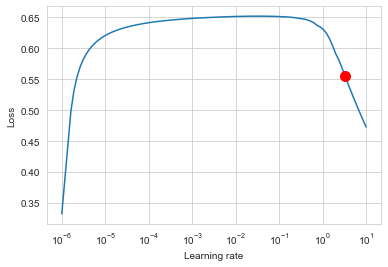

CPU times: total: 2min 27s
Wall time: 51.3 s


<timed exec>:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


In [26]:
%%time

# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

#### Train the model

In [27]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=1000,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=3.235936569296285/3,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 50.7k


In [28]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 32.0 K
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\cypri\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\cypri\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
target
1 2 3 -> 4 5 6 -> Ranking

1- define ranking target
2- rank

In [79]:
torch.__version__

'1.11.0'

### Results

In [66]:
actuals = torch.cat([y for x, (y, weight) in iter(test_dataloader)])
predictions = tft.predict(test_dataloader)
print((actuals - predictions).abs().mean().item())

predictions_np = predictions.cpu().detach().numpy()
actuals_np = actuals.cpu().detach().numpy()

0.0175495482981205


In [80]:
(actuals - baseline_predictions).abs().mean().item(), (actuals - predictions).abs().mean().item()

(0.01725354790687561, 0.0175495482981205)

In [81]:
baseline_predictions_np[0][0], baseline_predictions[0][0].item()

(-0.0031007752, -0.003100775182247162)

In [82]:
baseline_predictions_np.shape, baseline_predictions.shape

((2000, 10), torch.Size([2000, 10]))

In [83]:
predictions_np[0][0], predictions[0][0].item()

(0.0005853944, 0.0005853943875990808)

In [146]:
ts_max = df_test.Timestamp.max()
s = ts_max - max_prediction_length
base = np.arange(s+1, s+max_prediction_length+1)
real = df_test[(df_test.Timestamp > ts_max - max_prediction_length) & (df_test.SecuritiesCode == '1301')]['Timestamp'][-max_prediction_length:]
f = pd.Series(base).isin(real)

df_test_res = df_test.copy()
df_test_res_baseline = df_test.copy()

df_test_res['target_t0_t-1_pred'] = np.nan
df_test_res['target_t0_t-1_true'] = np.nan

df_test_res_baseline['target_t0_t-1_pred'] = np.nan
df_test_res_baseline['target_t0_t-1_true'] = np.nan

df_test_res['Target_pred'] = np.nan
df_test_res['Target_true'] = np.nan

df_test_res_baseline['Target_pred'] = np.nan
df_test_res_baseline['Target_true'] = np.nan


In [96]:
df_test_res.loc[(df_test_res.Timestamp > ts_max - max_prediction_length), 'target_t0_t-1_pred'] = predictions_np[:, f].flatten()
df_test_res.loc[(df_test_res.Timestamp > ts_max - max_prediction_length), 'target_t0_t-1_true'] = actuals_np[:, f].flatten()

# df_test_res['Target_true'] = df_test_res['target_t0_t-1_true'].shift(-2)
df_test_res = shift(df_test_res, from_='target_t0_t-1_true', to_='target_t0_t-1', shift=2)


df_test_res_baseline.loc[(df_test_res.Timestamp > ts_max - max_prediction_length), 'target_t0_t-1_pred'] = baseline_predictions_np[:, f].flatten()
df_test_res_baseline.loc[(df_test_res.Timestamp > ts_max - max_prediction_length), 'target_t0_t-1_true'] = actuals_np[:, f].flatten()




In [108]:
(df_test_res.Timestamp > ts_max - max_prediction_length).sum()

10000

In [98]:
## Keep only result which have been predicted
df_test_res = df_test_res[df_test_res.Timestamp > ts_max - max_prediction_length].copy()
df_test_res_baseline = df_test_res_baseline[df_test_res_baseline.Timestamp > ts_max - max_prediction_length].copy()
df_test_res

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Timestamp,target_t0_t-1,target_t0_t-1_pred,target_t0_t-1_true
49,20220221_1301,2022-02-21,1301,3200.0,3215.0,3190.0,3205.0,10300,1.0,0.0,False,-0.001563,19044,-0.003110,5.848494e-04,-0.003110
50,20220222_1301,2022-02-22,1301,3205.0,3215.0,3190.0,3200.0,9800,1.0,0.0,False,-0.014085,19045,-0.001560,5.847947e-04,-0.001560
51,20220224_1301,2022-02-24,1301,3195.0,3205.0,3175.0,3195.0,15200,1.0,0.0,False,0.036508,19047,-0.001563,5.847557e-04,-0.001563
52,20220225_1301,2022-02-25,1301,3160.0,3185.0,3135.0,3150.0,22200,1.0,0.0,False,-0.004594,19048,-0.014085,5.847490e-04,-0.014085
53,20220228_1301,2022-02-28,1301,3180.0,3265.0,3170.0,3265.0,28700,1.0,0.0,False,-0.007692,19051,0.036508,5.847434e-04,0.036508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107995,20220221_9997,2022-02-21,9997,725.0,729.0,719.0,727.0,116400,1.0,0.0,False,-0.002774,19044,-0.012228,2.994625e-07,-0.012228
107996,20220222_9997,2022-02-22,9997,719.0,723.0,711.0,721.0,225500,1.0,0.0,False,0.019471,19045,-0.008253,2.994088e-07,-0.008253
107997,20220224_9997,2022-02-24,9997,709.0,725.0,708.0,719.0,195600,1.0,0.0,False,0.001364,19047,-0.002774,2.993706e-07,-0.002774
107998,20220225_9997,2022-02-25,9997,725.0,738.0,724.0,733.0,170500,1.0,0.0,False,-0.001362,19048,0.019471,2.993643e-07,0.019471


In [144]:
df_test_res['Rank'] = (df_test_res.groupby("Date")["target_t0_t-1_true"].rank(ascending=False, method="first") - 1).astype(int)
df_test_res_baseline['Rank'] = (df_test_res_baseline.groupby("Date")["target_t0_t-1_true"].rank(ascending=False, method="first") - 1).astype(int)

In [145]:
from utilities.evaluation import calc_spread_return_sharpe

calc_spread_return_sharpe(df_test_res), calc_spread_return_sharpe(df_test_res_baseline)

(0.3011614454155651, 0.3011614454155651)